In [1]:
%load_ext autoreload
%autoreload 2

In [147]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
import os

from keras_helper import *
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib

import data_utils as dut
import complex_models as cmplxmod
from plot_utils import plot3

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
if tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
else:  # Use the Default Strategy
  strategy = tf.distribute.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [4]:
#print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if len(gpus):
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print("Restricting Memory")
  except RuntimeError as e:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Physical devices cannot be modified after being initialized


In [5]:
!nvidia-smi

Mon Aug 23 16:29:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:03:00.0 Off |                  N/A |
| 46%   29C    P0    27W / 105W |     91MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P4000        Off  | 00000000:04:00.0 Off |                  N/A |
| 46%   33C    P0    27W / 105W |    636MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### Some training parameters

In [6]:
path = './'

In [7]:
h,w=64,64
nepochs=60
wt_path = 'weights_cmplx_ft/basic'
batch_size = 32

if (not os.path.isdir(path+wt_path)):
    os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [8]:
data_path = '../data/'
data_diffr_red, real_space = dut.read_experimental_data(data_path)

In [9]:
amplitudes = np.abs(real_space)
phases = np.angle(real_space)
amplitudes.shape

(161, 161, 64, 64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


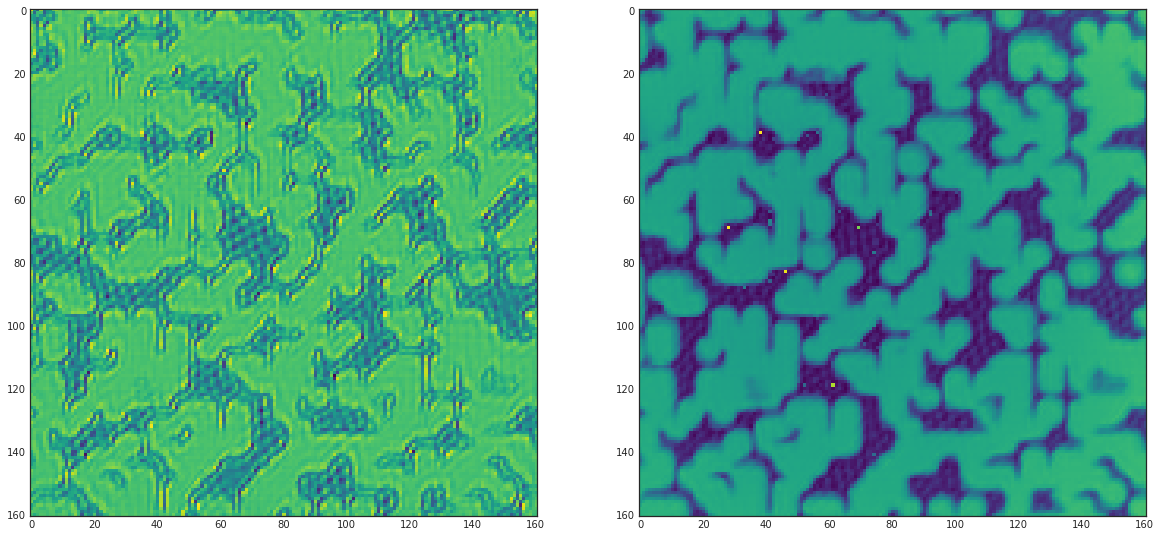

In [10]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amplitudes[:,:,32,32])
ax[1].imshow(phases[:,:,32,32])

In [225]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
X_train, Y_train, X_test, Y_test = dut.get_train_test_data(x_data=data_diffr_red,
                                                           y_data=real_space,
                                                           n_train_lines=nlines,
                                                           n_test_lines=nltest,
                                                           img_h=h,
                                                           img_w=w)

Indexing the test set from 101
Train shape (16100, 64, 64, 1) test shape (3600, 64, 64, 1)
Shuffling the data using random state 0


In [226]:
Y_train_ft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Y_train, axes=(1,2)), axes=(1,2), norm='ortho'), axes=(1,2))

In [227]:
Y_train.shape, X_train.shape

((16100, 64, 64, 1), (16100, 64, 64, 1))

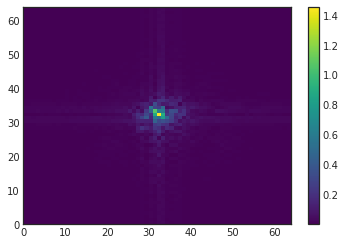

In [230]:
plt.pcolormesh(np.log(np.abs(Y_train_ft[0,...,0]) + 1))
plt.colorbar()

## Define the network structure

In [191]:
tf.keras.backend.clear_session()
np.random.seed(123)

files=glob.glob('%s/*' % wt_path)
for file in files:
    os.remove(file)

#plot_model(autoencoder, to_file='paper_data/str_model.png')


In [192]:
with strategy.scope():
    model = cmplxmod.create_unet_model(h, w)

Tensor("complex_conv2d_transpose/Identity_2:0", shape=(None, 16, 16, 128), dtype=complex64) Tensor("complex_conv2d_4/Identity_2:0", shape=(None, 16, 16, 128), dtype=complex64)
Tensor("complex_conv2d_transpose_1/Identity_2:0", shape=(None, 32, 32, 64), dtype=complex64) Tensor("complex_conv2d_2/Identity_2:0", shape=(None, 32, 32, 64), dtype=complex64)
Tensor("complex_conv2d_transpose_2/Identity_2:0", shape=(None, 64, 64, 32), dtype=complex64) Tensor("complex_conv2d/Identity_2:0", shape=(None, 64, 64, 32), dtype=complex64)


In [193]:
out = model(X_train[0][None, :])

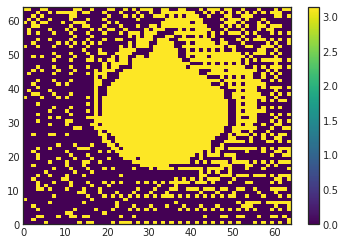

In [194]:
plt.pcolormesh(np.angle(np.squeeze(np.angle(out))))
plt.colorbar()

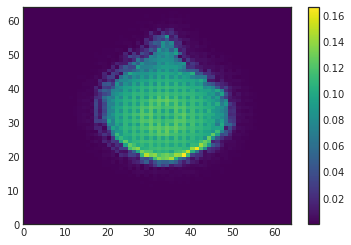

In [195]:
plt.pcolormesh(np.abs(np.squeeze(out)))
plt.colorbar()

In [196]:
cmplxmod.full_summary(model)

summary for model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
complex_conv2d (ComplexConv2D)  (None, 64, 64, 32)   640         input_1[0][0]                    
__________________________________________________________________________________________________
complex_conv2d_1 (ComplexConv2D (None, 32, 32, 32)   18496       complex_conv2d[0][0]             
__________________________________________________________________________________________________
complex_conv2d_2 (ComplexConv2D (None, 32, 32, 64)   36992       complex_conv2d_1[0][0]           
____________________________________________________________________________

In [197]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [198]:
histories = []

In [203]:
for i in range(1):
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=2, min_lr=0.0001, verbose=1)


    checkpoints= tf.keras.callbacks.ModelCheckpoint(wt_path + '/weights' + '.{epoch:02d}.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, 
                                                    save_weights_only=True, mode='auto', save_freq='epoch')




    history = model.fit(X_train, Y_train_ft, shuffle=True, batch_size=batch_size, verbose=1,
                              epochs=5, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])
    histories.append(history)

Epoch 1/5
478/478 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00001: val_loss improved from inf to 0.01472, saving model to weights_cmplx_ft/basic/weights.01.h5
478/478 [==============================] - 57s 120ms/step - loss: 0.0147 - val_loss: 0.0147 - lr: 0.0010
Epoch 2/5
478/478 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00002: val_loss improved from 0.01472 to 0.01464, saving model to weights_cmplx_ft/basic/weights.02.h5
478/478 [==============================] - 58s 121ms/step - loss: 0.0147 - val_loss: 0.0146 - lr: 0.0010
Epoch 3/5
478/478 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00003: val_loss improved from 0.01464 to 0.01463, saving model to weights_cmplx_ft/basic/weights.03.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
478/478 [==============================] - 57s 119ms/step - loss: 0.0147 - val_loss: 0.0146 - lr: 0.0010
Epoch 4/5
478/478 [==============================] - 

In [204]:
histories

## Plot metrics of the training

In [212]:
for i in range(len(histories)):
    if i == 0:
        epochs = np.array(histories[0].epoch)
        training_losses = np.array(histories[0].history['loss'])
        val_losses =np.array(histories[0].history['val_loss'])
    else:
        epochs = np.concatenate([epochs, epochs[-1] + np.array(histories[i].epoch) + 1], axis=0)
        training_losses = np.concatenate([training_losses,  histories[i].history['loss']], axis=0)
        val_losses =  np.concatenate([val_losses, histories[i].history['val_loss']], axis=0)

Text(0.5, 0, 'Epochs')

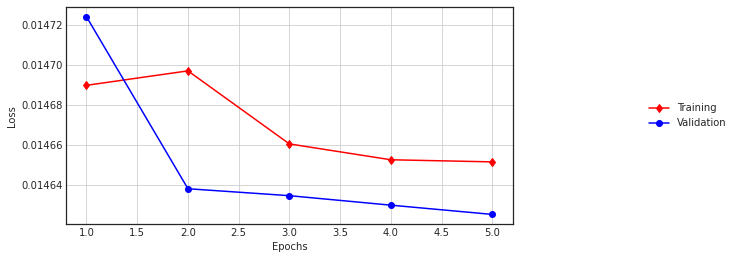

In [213]:
f, axarr = plt.subplots(1, sharex=True, figsize=(8, 4))

axarr.set(ylabel='Loss')
axarr.plot(epochs[1:], training_losses[1:], color='red', marker='d', markevery=0.2, label='Training')
axarr.plot(epochs[1:], val_losses[1:], color='blue', marker='o', markevery=0.2, label='Validation')
axarr.grid()
axarr.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')

#axarr[1].set(ylabel='Loss')
#axarr[1].plot(epochs,hist_large.history['conv2d_12_loss'], 'C0o', label='Structure Training')
#axarr[1].plot(epochs,hist_large.history['val_conv2d_12_loss'], 'C0-', label='Structure Validation')
#axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

#plt.tight_layout()
#axarr[1].grid()


#axarr[2].set(ylabel='Loss')
#axarr[2].plot(epochs,hist_large.history['conv2d_19_loss'], 'C0o', label='Phase Training')
#axarr[2].plot(epochs,hist_large.history['val_conv2d_19_loss'], 'C0-', label='Phase Validation')
#axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
#plt.tight_layout()
#axarr[2].grid()

#plt.show()

#print(np.min(hist_large.history['val_conv2d_12_loss']), np.min(hist_large.history['val_conv2d_19_loss']), np.min(hist_large.history['val_loss']))

### Save the epoch with the lowest validation loss
(PtychoNN will use these weights)

In [216]:
min_epoch = np.argmin(val_losses)
print (min_epoch)
np.save(f'{path}/{wt_path}/min_epoch', min_epoch)

5


In [217]:
!ls weights_cmplx_ft/basic

min_epoch.npy  weights.02.h5  weights.04.h5
weights.01.h5  weights.03.h5  weights.05.h5


### Load the model from the epoch with lowest validation error

In [218]:
min_epoch = np.load(f'{wt_path}/min_epoch.npy')

model_loaded = cmplxmod.create_unet_model(h, w)

model_loaded.load_weights(f'{wt_path}/weights.{min_epoch:02}.h5')

#model = load_model(f'{wt_path}/weights.{min_epoch:02}.hdf5')
print ("Loaded model from epoch:%d" %min_epoch)

preds_intens=np.array(model.predict(X_test))
print (preds_intens[0].shape)

Tensor("complex_conv2d_transpose_9/Identity:0", shape=(None, 16, 16, 128), dtype=complex64) Tensor("complex_conv2d_34/Identity:0", shape=(None, 16, 16, 128), dtype=complex64)
Tensor("complex_conv2d_transpose_10/Identity:0", shape=(None, 32, 32, 64), dtype=complex64) Tensor("complex_conv2d_32/Identity:0", shape=(None, 32, 32, 64), dtype=complex64)
Tensor("complex_conv2d_transpose_11/Identity:0", shape=(None, 64, 64, 32), dtype=complex64) Tensor("complex_conv2d_30/Identity:0", shape=(None, 64, 64, 32), dtype=complex64)
Loaded model from epoch:5
(64, 64, 1)


In [219]:
preds_ft = model_loaded.predict(X_test)

In [220]:
preds_ft = np.exp(preds_ft - 1)

### Make prediction using the diffraction data alone

In [221]:
preds = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(preds_ft, axes=(1,2)), axes=(1,2), norm='ortho'), axes=(1,2))
preds_intens = np.array([np.abs(preds), np.angle(preds)])

# Plot some instances of the test data, it's FT and the CNN prediction

In [222]:
preds_intens.shape

(2, 3600, 64, 64, 1)

In [223]:
Y_test.shape

(3600, 64, 64, 1)

<Figure size 432x288 with 0 Axes>

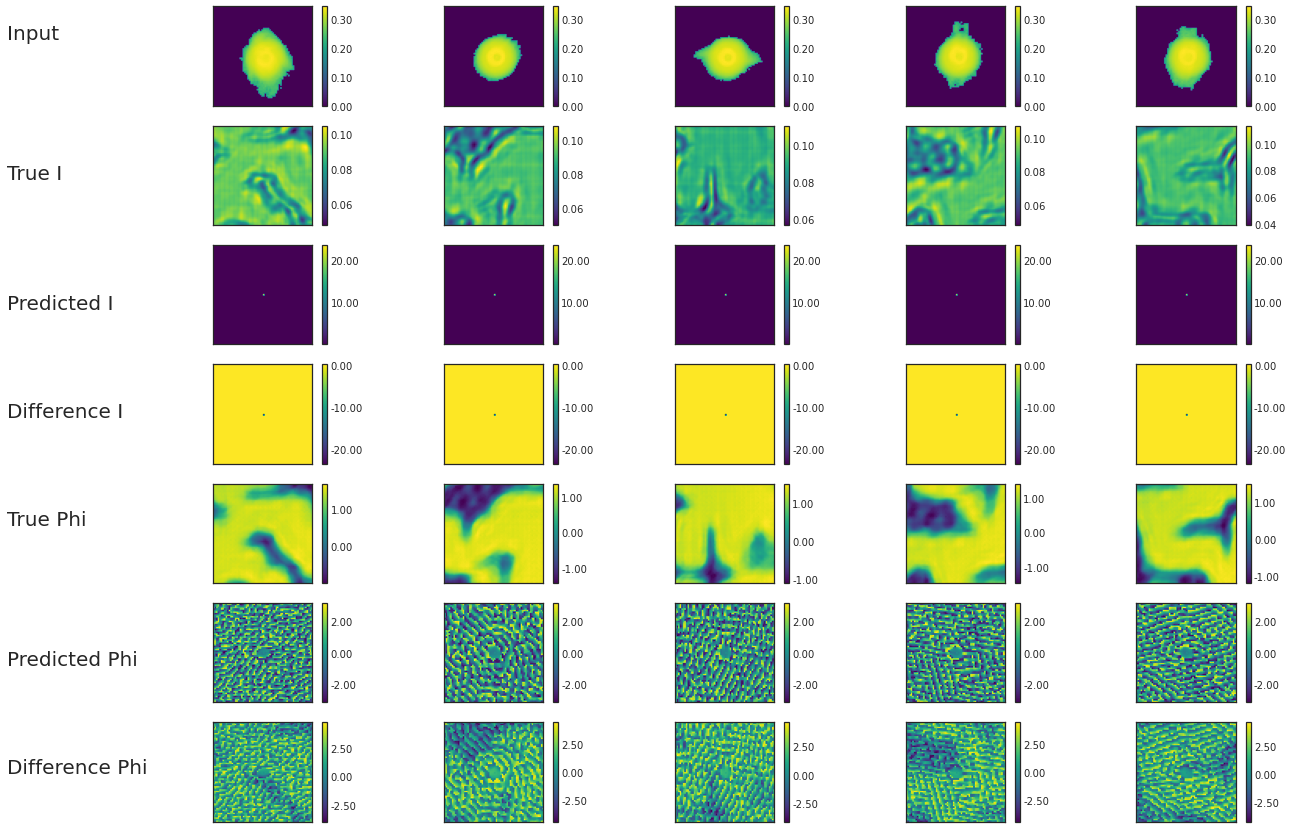

In [224]:
h,w = 64, 64
ntest = preds_intens[0].shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(np.abs(X_test[j]).reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(np.abs(Y_test[j]).reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(np.angle(Y_test[j]).reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(np.abs(Y_test[j]).reshape(h, w)-preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(np.angle(Y_test[j]).reshape(h, w)-preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [149]:
point_size = 3
overlap = 4*point_size

In [150]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = preds_intens[0].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [151]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = preds_intens[1].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [152]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [153]:
true_amp = np.abs(Y_test).reshape(nltest, nltest, 64,64)
true_ph = np.angle(Y_test).reshape(nltest, nltest, 64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


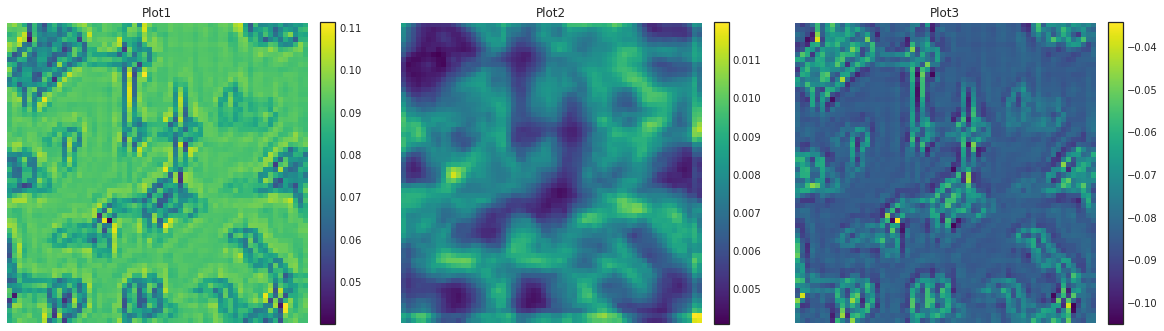

In [154]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

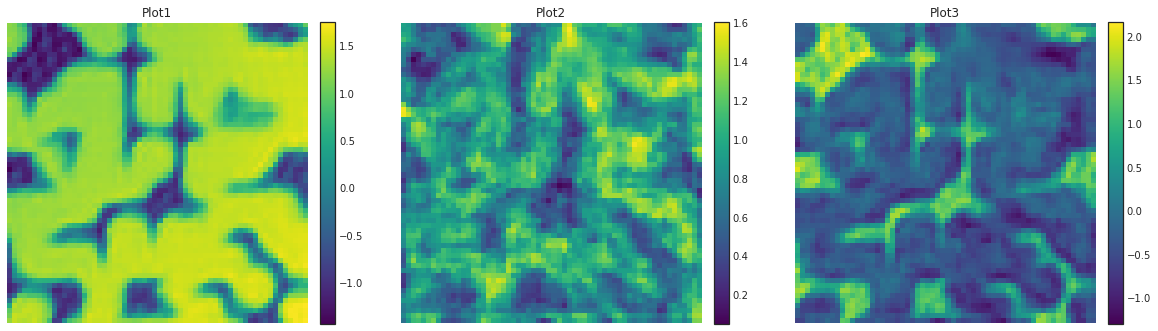

In [155]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [156]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  0.006563709649245649
MSE in phase:  0.4371613341767932
